<a href="https://www.kaggle.com/code/angelchaudhary/why-forecasts-drift-over-time?scriptVersionId=290383407" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# A Rolling Window Evaluation Case Study

## What is this about?
Forecasting models are usually trained on historical data and then deployed with the assumption that future data will behave similarly. In reality, data changes over time and user behavior evolves, markets shift, and external conditions fluctuate. As a result, models that once performed well can slowly become inaccurate. This phenomenon is known as **forecast drift**.

### Objective
The goal of this case study is to understand how and why forecasting performance degrades over time, and to evaluate whether rolling window training helps models stay relevant as data distributions change.

### Why are we doing this?
Most projects report a single train–test score and stop there. However, real world forecasting systems operate continuously, where:
- data is time-dependent,
- old patterns lose relevance,
- static models silently decay.

By studying performance over time, we move closer to how forecasting models behave in production — not just on paper.

### Approach 
We are going to simulate a time-series forecasting problem and evaluate the model using a rolling window strategy that the model is repeatedly retrained on the most recent data window, predictions are made for the immediate future and performance is tracked across time. This allows us to observe when drift happens, how fast it impacts accuracy and whether frequent retraining helps mitigate it.

By the end of this notebook, we focus less on a single accuracy score and more on model stability, robustness, and realworld reliability.

# LET'S DO IT!!!
![FUNNY GIF](https://media.giphy.com/media/v1.Y2lkPWVjZjA1ZTQ3cXdwbTh3Zms3eWI4NmdqaDVoemlkcTI5aGFjaXh3d2dxNGNpdTIyayZlcD12MV9naWZzX3NlYXJjaCZjdD1n/ue5ZwFCaxy64M/giphy.gif)

# Problem Setup

### The forecasting task
We'll study a univariate time series forecasting problem where the objective is to predict future values using past observations. Since the data is time ordered so the model is only allowed to learn from historical information with no access to future data at any point. At each time step, recent observations are used to forecast the next value in the series.

### The core challenge
Unlike traditional setups that assume a stable data distribution, we allow the underlying patterns to change over time. This means relationships learned earlier may gradually lose relevance, causing model performance to decline even when the model itself remains unchanged. As a result, a single accuracy score is often insufficient to judge real-world reliability.

### Evaluation mindset
Instead of relying on one train–test split, we evaluate the model continuously over time by repeatedly training on past data and testing on the immediate future. By tracking performance as time progresses, this setup closely reflects how forecasting models behave in production, where adaptation to new data is critical.

## Rolling Window Evaluation Strategy
In a rolling window setup, the model is not trained once and frozen. Instead, it is retrained repeatedly using the most recent slice of data. At each point in time, a fixed-size window of past observations is used for training, and the model is then evaluated on the data that comes immediately after this window.

As time moves forward, both the training window and the test point slide ahead together. Older data is dropped, newer data is added, and the model is updated accordingly. This ensures that the model is always learning from the most relevant information available at that moment.

In [1]:
# Synthetic Data Generation
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

np.random.seed(42)

n_points = 1500
time = np.arange(n_points)

# Base components
trend = 0.002 * time
seasonality = np.sin(2 * np.pi * time / 50)

# Gradual drift: increasing amplitude over time
drift = 1 + 0.001 * time
noise = np.random.normal(0, 0.3, size=n_points)
time_series = drift * seasonality + trend + noise


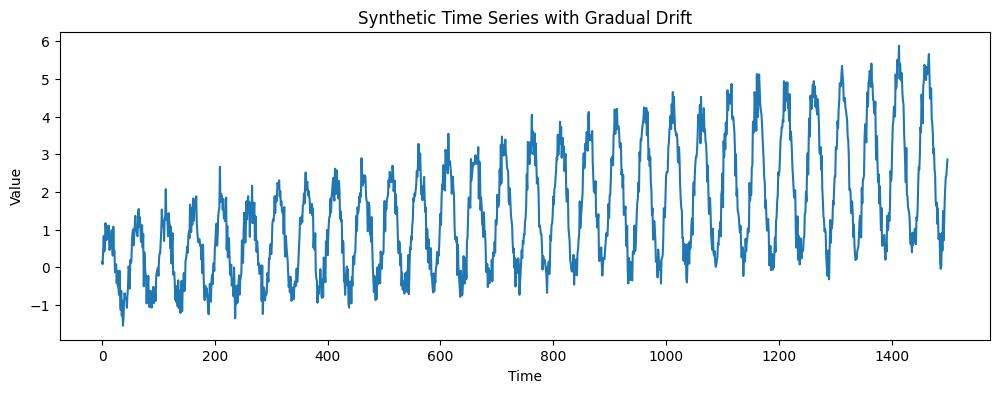

In [2]:
# Visuals
plt.figure(figsize=(12, 4))
plt.plot(time_series)
plt.title("Synthetic Time Series with Gradual Drift")
plt.xlabel("Time")
plt.ylabel("Value")
plt.show()


This synthetic series has a clear temporal structure (trend + seasonality),noise to avoid perfect predictability and a slowly changing amplitude that introduces distribution shift. Because the drift is gradual rather than abrupt, it reflects how real-world forecasting systems often fail silently over time.

## Baseline Forecasting Model

We start with a simple forecasting model trained on an initial slice of the time series. The purpose of this baseline is not to achieve the best possible accuracy, but to establish a reference point for understanding how performance changes as time progresses. And the model predicts the next value in the series using a fixed number of past observations (lag features). A linear regression model is used to keep the behavior interpretable and to avoid masking drift effects with excessive model complexity.

In [3]:
# creating the lagged features
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

def create_lag_features(series, n_lags):
    X, y = [], []
    for i in range(n_lags, len(series)):
        X.append(series[i - n_lags:i])
        y.append(series[i])
    return np.array(X), np.array(y)


In [4]:
# baseline model training 
WINDOW_SIZE = 200
N_LAGS = 10

train_series = time_series[:WINDOW_SIZE]
test_series = time_series[WINDOW_SIZE:WINDOW_SIZE + 100]

X_train, y_train = create_lag_features(train_series, N_LAGS)
X_test, y_test = create_lag_features(np.concatenate([train_series[-N_LAGS:], test_series]),N_LAGS
)

baseline_model = LinearRegression()
baseline_model.fit(X_train, y_train)

preds = baseline_model.predict(X_test)
mse = mean_squared_error(y_test, preds)

mse


0.14789372244121507

This baseline score represents model performance before significant drift accumulates. At this stage, the model is trained once and evaluated shortly after, similar to a traditional train–test setup.

## Rolling Window Evaluation

Rolling window evaluation simulates how a forecasting model behaves once deployed. Instead of training the model once, we retrain it repeatedly on the most recent data, make a short-horizon prediction, and record the error. As time progresses, the training window slides forward, allowing us to observe how performance changes as the data distribution drifts.

This approach reveals when and how fast a model starts to fail, something a single train–test split cannot capture.

In [5]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

WINDOW_SIZE = 200
N_LAGS = 10
HORIZON = 1

errors = []
timestamps = []

for t in range(WINDOW_SIZE, len(time_series) - HORIZON):
    train_series = time_series[t - WINDOW_SIZE:t]
    test_series = time_series[t:t + HORIZON]

    X_train, y_train = create_lag_features(train_series, N_LAGS)

    X_test, y_test = create_lag_features(
        np.concatenate([train_series[-N_LAGS:], test_series]),
        N_LAGS
    )

    model = LinearRegression()
    model.fit(X_train, y_train)

    preds = model.predict(X_test)
    mse = mean_squared_error(y_test, preds)

    errors.append(mse)
    timestamps.append(t)


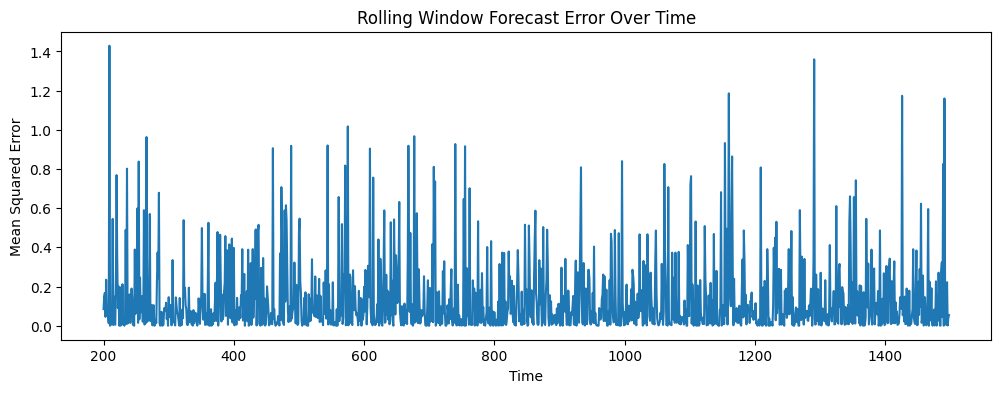

In [6]:
# visualizing 
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))
plt.plot(timestamps, errors)
plt.title("Rolling Window Forecast Error Over Time")
plt.xlabel("Time")
plt.ylabel("Mean Squared Error")
plt.show()


## Interpreting the Results
The plot above shows the rolling forecast error over time. Rather than remaining constant, the error fluctuates and occasionally spikes. These spikes indicate periods where patterns learned from recent history no longer align well with the immediate future, a clear signal of forecast drift. This behavior would be invisible in a single train test evaluation. Even though the model is continuously retrained, performance still degrades at certain points, highlighting that retraining alone does not fully eliminate the impact of distributional change.

This confirms that forecast drift is not a binary failure but a gradual and recurring phenomenon, reinforcing the need for time-aware evaluation strategies in real world forecasting systems.

## Static Model vs Rolling Window Model

To understand the value of rolling retraining, we compare it against a static baseline model trained once and never updated.

In [7]:
# Static model evaluation 
# Train once on initial window
static_model = LinearRegression()
static_model.fit(X_train, y_train)

static_errors = []

for t in range(WINDOW_SIZE, len(time_series) - N_LAGS):
    input_window = time_series[t - N_LAGS:t].reshape(1, -1)
    prediction = static_model.predict(input_window)[0]
    true_value = time_series[t]
    static_errors.append((prediction - true_value) ** 2)


In [8]:
np.mean(static_errors), np.mean(errors)


(np.float64(0.17982457935448623), np.float64(0.13347804776837605))

## Comparing Static vs Rolling Window Performance

To understand the impact of retraining, we compare two evaluation strategies:

**Static model**: trained once on an initial window and used to predict all future points.

**Rolling window model**: retrained continuously on the most recent data window before each prediction.

For both approaches, we track the mean squared error (MSE) over time and compute their average error across the full horizon.

The results show:
- Static model average error ≈ 0.18
- Rolling window average error ≈ 0.13

This gap indicates that retraining on recent data leads to consistently better forecasting performance over time.

## Key Takeaways
This case study highlights an important real-world lesson:
forecasting performance should be evaluated as a function of time, not as a single number.

While the static model may appear reasonable initially, its performance degrades as historical patterns become outdated. Rolling window retraining improves robustness by continuously aligning the model with the most recent data behavior. Rather than optimizing for peak accuracy at one point in time, effective forecasting systems should prioritize the adaptability, stability under distribution shift and long-term reliability in production settings.